In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import seaborn as sns
from nltk.tokenize import word_tokenize
import string, re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from nltk.probability import FreqDist
from itertools import chain
string.punctuation
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/singh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/singh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT
2,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
3,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
4,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ


In [4]:
df.shape

(60000, 6)

In [5]:
df.isna().sum()

Id              0
Title           0
Body            0
Tags            0
CreationDate    0
Y               0
dtype: int64

In [6]:
df.Y.value_counts()

LQ_CLOSE    20000
HQ          20000
LQ_EDIT     20000
Name: Y, dtype: int64

#### Removing tags

In [7]:
def remove_tags(text):
    tag_re = re.compile(r'<[^>]+>')
    return tag_re.sub('', text)

In [8]:
df['Body'] = df['Body'].apply(remove_tags)

In [9]:
data = df['Body']
target = df['Y']

#### Setting stopwords and punchuations

In [10]:
sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©', 'It', 
            'said', 'one', 'com', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'
           ,'-', 'lt']
sw_set = set(sw_list)

In [11]:
# we can define a function that removes stopwords 
def process_article(article):
    tokens = nltk.word_tokenize(article)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in sw_set]
    return stopwords_removed

In [12]:
# applying the above function to our data/features 
processed_data = list(map(process_article, data))

In [13]:
processed_data[0]

["'m",
 'already',
 'familiar',
 'repeating',
 'tasks',
 'every',
 'n',
 'seconds',
 'using',
 'java.util.timer',
 'java.util.timertask',
 'lets',
 'say',
 'want',
 'print',
 'hello',
 'world',
 'console',
 'every',
 'random',
 'seconds',
 '1-5',
 'unfortunately',
 "'m",
 'bit',
 'rush',
 "n't",
 'code',
 'show',
 'far',
 'help',
 'would',
 'apriciated']

In [14]:
lemmatizer = WordNetLemmatizer()
# create a function  and loop through each word in  a review
def lemmatization(review):
    lemma_list=[]
    for word in review:
        lemma_word=lemmatizer.lemmatize(word,pos='v') 
        lemma_list.append(lemma_word)
    return lemma_list

# lematize the stem_data
lemmatize_data = list(map(lemmatization, processed_data))

In [15]:
df['cleaned_data'] = lemmatize_data

In [16]:
df.head()

,Id,Title,Body,Tags,CreationDate,Y,cleaned_data
0,34552656,Java: Repeat Task Every Random Seconds,I'm already familiar with repeating tasks ever...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE,"['m, already, familiar, repeat, task, every, n..."
1,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT,"[different, table, like, select, system, selec..."
2,34553034,Why are Java Optionals immutable?,I'd like to understand why Java 8 Optionals we...,<java><optional>,2016-01-01 02:03:20,HQ,"['d, like, understand, java, optionals, design..."
3,34553174,Text Overlay Image with Darkened Opacity React...,I am attempting to overlay a title over an ima...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ,"[attempt, overlay, title, image, image, darken..."
4,34553318,Why ternary operator in swift is so picky?,"The question is very simple, but I just could ...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ,"[question, simple, could, find, answer, return..."


In [17]:
df['target'] = np.where(df['Y'] == 'HQ', 2, df['Y'])
df['target'] = np.where(df['Y'] == 'LQ_EDIT', 1, df['target'])
df['target'] = np.where(df['Y'] == 'LQ_CLOSE', 0, df['target'])

In [18]:
negative = df[df.target == 0]['cleaned_data']
neutral = df[df.target == 1]['cleaned_data']
positive = df[df.target == 2]['cleaned_data']

In [19]:
neg_re = pd.DataFrame(pd.Series(chain(*negative)).value_counts()).sort_values(by=0,ascending=False).reset_index()

neutral_re = pd.DataFrame(pd.Series(chain(*neutral)).value_counts()).sort_values(by=0,ascending=False).reset_index()

pos_re = pd.DataFrame(pd.Series(chain(*positive)).value_counts()).sort_values(by=0,ascending=False).reset_index()

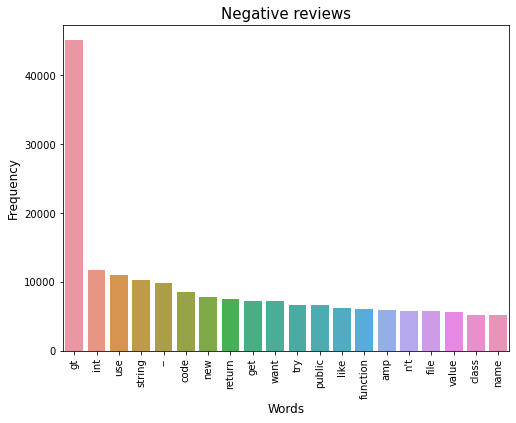

In [20]:
plt.figure(figsize=(8,6))
sns.barplot(neg_re['index'][:20],neg_re[0][:20])
plt.xticks(rotation=90)
plt.title('Negative reviews', fontsize = 15)
plt.xlabel('Words', fontsize = 12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

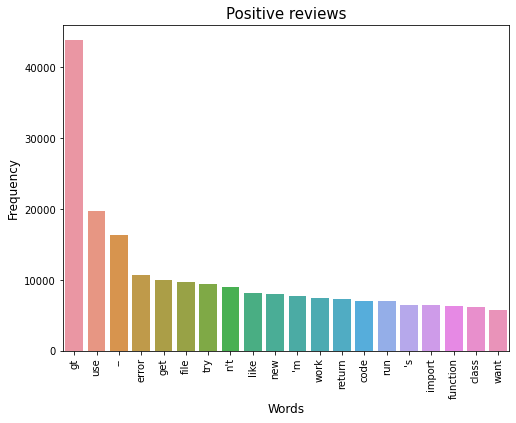

In [21]:
plt.figure(figsize=(8,6))
sns.barplot(pos_re['index'][:20],pos_re[0][:20])
plt.xticks(rotation=90)
plt.title('Positive reviews', fontsize = 15)
plt.xlabel('Words', fontsize = 12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

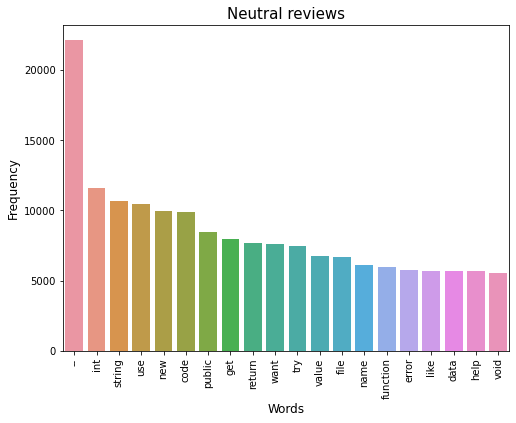

In [22]:
plt.figure(figsize=(8,6))
sns.barplot(neutral_re['index'][:20],neutral_re[0][:20])
plt.xticks(rotation=90)
plt.title('Neutral reviews', fontsize = 15)
plt.xlabel('Words', fontsize = 12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

### Count Vector

In [23]:
#vec = CountVectorizer(stop_words=None)
#X = vec.fit_transform(X_lem)

#d = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
#d

In [24]:
#d.head()